# Analysis of the country in the manual normalization CSV data

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
pd.options.display.max_colwidth = 100 # Avoid "..." in large strings

There are at least two sources of data we can use to analyze the country information:
a CSV with some \[unfinished] manually normalized information,
and the Clea CSV output dataset.
The latter was already analyzed in the
[2018-06 country experiments](experiments_2018-06_country.ipynb),
this time we'll try to perform a similar graph analysis
on the former CSV.

## Loading the manual normalization CSV data

This data have the fields names written in Portuguese, and the *ISO-3166* name is misspelled in the country column name (*ISO-3661* regards to *end-suction centrifugal pumps*, which has nothing to do with countries):

In [3]:
ndata = pd.read_csv("aff_n15.csv",
                    sep="|",
                    dtype=str,
                    keep_default_na=False) \
          .drop_duplicates()
ndata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 506786 entries, 0 to 506785
Data columns (total 15 columns):
coleção                                  506786 non-null object
PID                                      506786 non-null object
ano de publicação                        506786 non-null object
tipo de documento                        506786 non-null object
título                                   506786 non-null object
número                                   506786 non-null object
normalizado                              506786 non-null object
id de afiliação                          506786 non-null object
instituição original                     506786 non-null object
paises original                          506786 non-null object
instituição normalizada                  506786 non-null object
país normalizado ISO-3661                506786 non-null object
código de país normalizado ISO-3166      506786 non-null object
estado normalizado ISO-3166              506786 non-null 

$98.27\%$ of the entries regards to Brazil, and there are just a few country names:

In [4]:
ndata_name_count = ndata["país normalizado ISO-3661"].value_counts()
ndata_name_count["Brazil"] / ndata_name_count.sum()

0.9827343296776154

In [5]:
ndata_name_count

Brazil                                                        498036
Portugal                                                        2733
Argentina                                                       1779
Iran                                                            1329
Colombia                                                         951
United States                                                    769
México                                                           405
Canada                                                           386
Uruguay                                                          375
Universidade de São Paulo                                          4
Universidade Federal do Rio Grande do Sul                          2
Universidade Tuiuti do Paraná                                      1
Empresa Brasileira de Pesquisa Agropecuária - Agrobiologia         1
Universidade Federal de Minas Gerais                               1
Universidade Federal de Santa Mari

*Netherlands* is the only country with less than a hundred entries, these other names are mostly university names, not country names. Therefore, we have just $10$ distinct countries, and clearly this dataset doesn't have everything sanitized.

In [6]:
ndata_has_country = ndata[ndata["país normalizado ISO-3661"].str.len() <= 13]

On the other hand, we've got $11$ distinct country codes, $98.17\%$ of them being **BR**: 

In [7]:
ndata_code_count = ndata["código de país normalizado ISO-3166"].value_counts()
ndata_code_count["BR"] / ndata_code_count.sum()

0.9816687911662911

In [8]:
ndata_code_count

BR         497496
PT           2733
AR           1779
IR           1329
CO            951
US            769
RB            540
MX            405
CA            386
UY            375
Brazil         21
NL              1
Uruguay         1
Name: código de país normalizado ISO-3166, dtype: int64

*Brazil* should have been **BR** and *Uruguay* should have been **UY**.
The adjacency pairs list has few entries:

In [9]:
df_ndata = pd.DataFrame(
    ndata.groupby(["país normalizado ISO-3661",
                   "código de país normalizado ISO-3166"])
         .size(),
    columns=["count"]
).reset_index().rename(columns={
    "país normalizado ISO-3661": "name",
    "código de país normalizado ISO-3166": "code",
}).sort_values(["code", "name", "count"])
df_ndata

,name,code,count
0,Argentina,AR,1779
1,Brazil,BR,497496
5,Empresa Brasileira de Pesquisa Agropecuária - Agrobiologia,Brazil,1
6,Fundação Getúlio Vargas,Brazil,1
7,Instituto Federal Goiano,Brazil,1
14,Universidade Estadual de Maringá,Brazil,1
15,Universidade Estadual do Centro-Oeste,Brazil,1
16,Universidade Federal da Grande Dourados,Brazil,1
17,Universidade Federal de Alfenas,Brazil,1
18,Universidade Federal de Minas Gerais,Brazil,1


Let's see the graph of these.

In [10]:
df_edges_list = df_ndata.assign(
    name=df_ndata["name"].apply(lambda x: f"name={x}"),
    code=df_ndata["code"].apply(lambda x: f"code={x}"),
)
names = df_edges_list["name"].unique()
codes = df_edges_list["code"].unique()

In [11]:
graph = nx.Graph()
graph.add_nodes_from(names, bipartite=0)
graph.add_nodes_from(codes, bipartite=1)
graph.add_weighted_edges_from(df_edges_list.values)
nx.is_bipartite(graph)

True

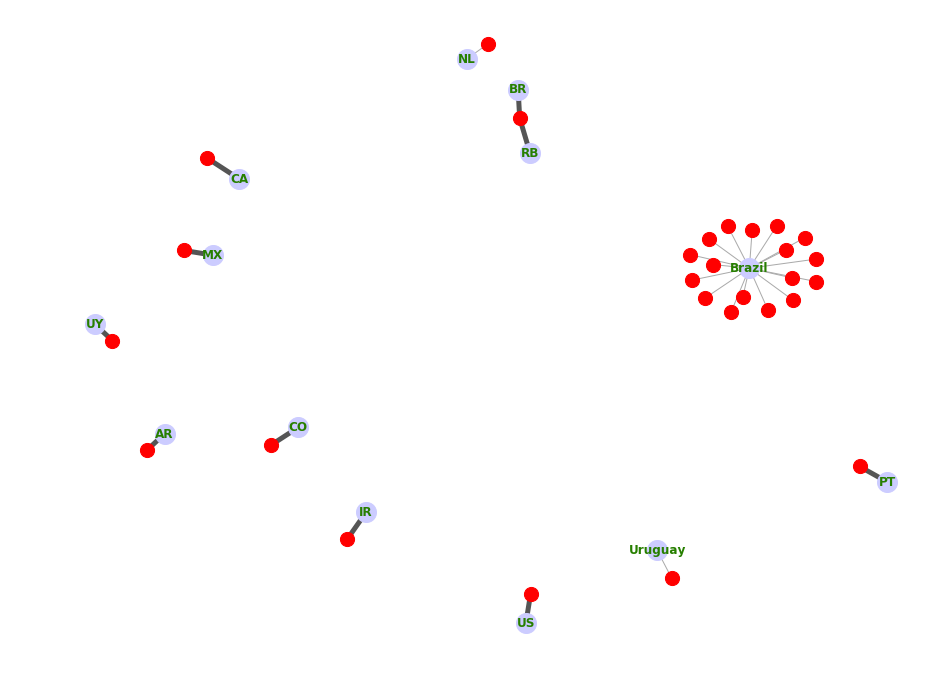

In [12]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.set_axis_off()

pos = nx.spring_layout(graph, k=.2, weight=None, random_state=11)

edges_small, edges_big = [], []
for edge, weight in nx.get_edge_attributes(graph, "weight").items():
    [edges_small, edges_big][weight > 10].append(edge)

nx.draw_networkx_edges(graph, pos, ax=ax, edgelist=edges_big,
                       width=5, edge_color="#555555")
nx.draw_networkx_edges(graph, pos, ax=ax, edgelist=edges_small,
                       width=1, edge_color="#aaaaaa")
nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=names.tolist(),
                       node_color="red", node_size=200)
nx.draw_networkx_nodes(graph, pos, ax=ax, nodelist=codes.tolist(),
                       node_color="#ccccff", node_size=400)
nx.draw_networkx_labels(graph, pos, ax=ax,
                        font_size=12, font_color="#277f00", font_weight="bold",
                        labels={code: code[5:] for code in codes})

plt.show()

The red nodes are country names,
whereas the labeled nodes are country codes.
Given that image, the only graph inconsistency we can find
(i.e., the only subgraph with at least two code nodes)
is the one where the **BR** and **RB** codes connect to *Brazil*.
As **RB** isn't a ISO-3166-2 alpha-2 code, it's clearly just a typoed **BR**.
There's no graph inconsistency in this data, nor empty values,
so we can simply join the entries with **BR**, **RB** and **Brazil** codes,
as well as join the **UY** and **Uruguay** codes.
That's enough to finish the normalization of this partially normalized CSV.